In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import gc
from train import train
from input_transformer import InputTransformer
from pytorch_pretrained_biggan import BigGAN
from input_noise_dataset import NoiseDataset

In [3]:
device = torch.device("cuda")

torch.set_printoptions(sci_mode=False)

In [4]:
torch.cuda.empty_cache()
model = InputTransformer().to(device)
torch.cuda.empty_cache()
print("Number of parameters:", model.getNumberOfParameters())

Number of parameters: 566128


In [5]:
dataset = NoiseDataset()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [6]:
biggan = BigGAN.from_pretrained('biggan-deep-512').to(device)
torch.cuda.empty_cache()

In [7]:
discriminator = torch.load("trained_models/abstract_image_discriminator.pkl").to(device)
feedbackPredictor = torch.load("trained_models/feedback_predictor.pkl").to(device)
torch.cuda.empty_cache()

In [8]:
def loss(prediction, label):
    generatedImage = biggan(prediction[0], prediction[1], 0.99)
    isAbstract = discriminator(generatedImage)
    feedback = feedbackPredictor(generatedImage)
    del generatedImage
    gc.collect()
    torch.cuda.empty_cache()
    return torch.sum((1-isAbstract) + (1-(feedback/5)))

In [9]:
model = train(model, optimizer, loss, dataset, device, epochs=1, batchSize=1, countAccuracy=False)

Epoch 1/1
----------

Progress: 100%

Loss: 0.6275 Accuracy: 0.0000 Duration: 21m 36s



In [10]:
torch.save(model, 'trained_models/input_transformer.pkl')

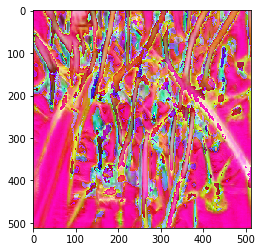

Abstractness: 1.00
Feedback: 4.62


In [48]:
initialInput = dataset[0][0].to(device)
transformedInput = model(initialInput)
generatedImage = biggan(transformedInput[0], transformedInput[1], 0.99)
isAbstract = discriminator(generatedImage).item()
feedback = feedbackPredictor(generatedImage).item()
pilImage = torchvision.transforms.ToPILImage()(torch.squeeze(generatedImage.cpu(), dim=0))
del generatedImage
gc.collect()
torch.cuda.empty_cache()
plt.imshow(pilImage)
plt.show()

print("Abstractness: {:.2f}".format(isAbstract))
print("Feedback: {:.2f}".format(feedback))